# Potato Disease Classification

### Import all the Dependencies

In [169]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


### Set all the Constants

In [170]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [171]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "cat_converted",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 378 files belonging to 2 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/VFEOskzhhbc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [173]:
EPOCHS = 50
class_names = dataset.class_names
print(class_names)

['healthy', 'sick']


(32, 256, 256, 3)


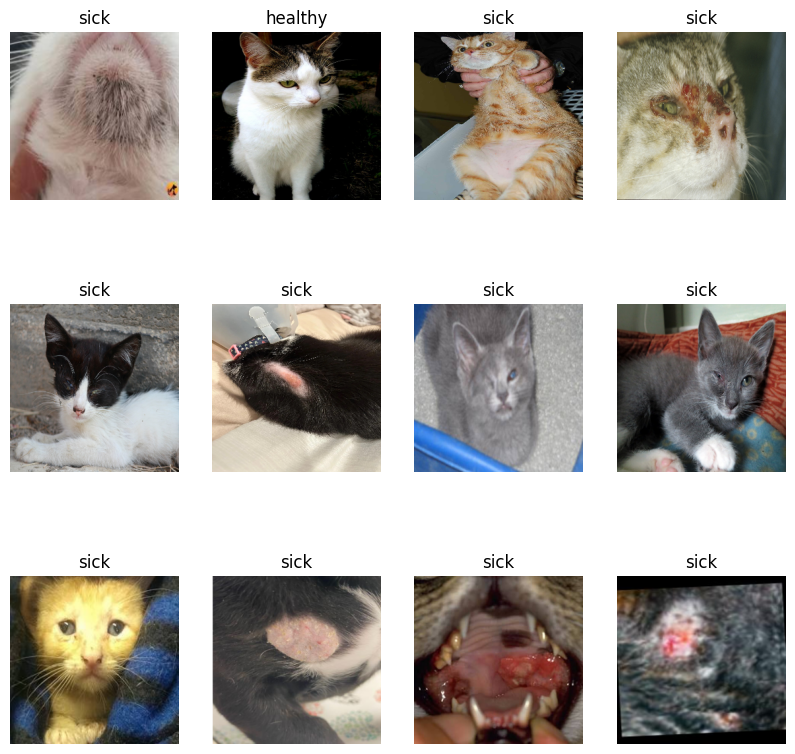

In [174]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    plt.figure(figsize=(10, 10))
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
    plt.show()

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

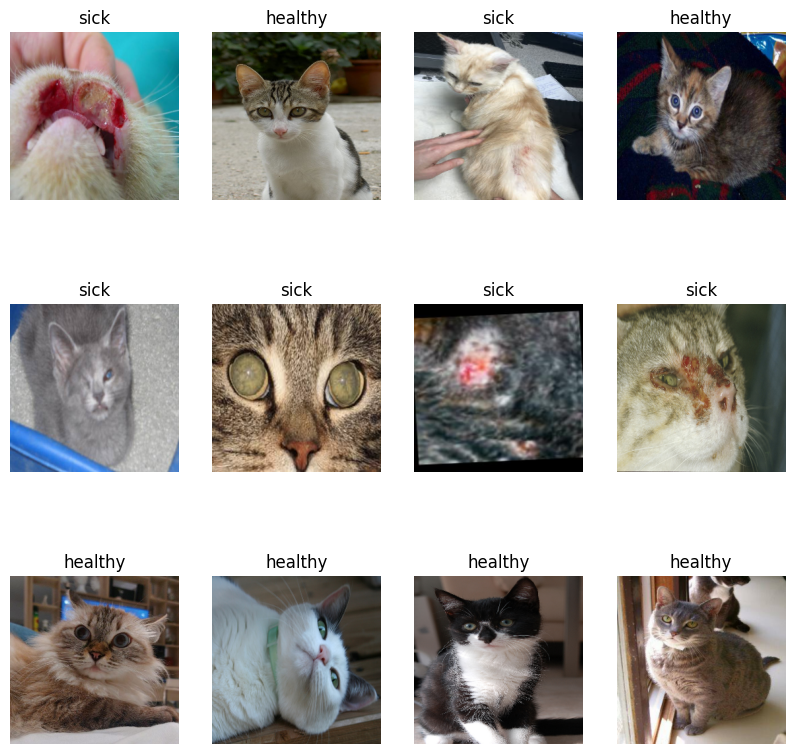

In [175]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [176]:
print(labels_batch.numpy())
len(dataset)


[1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1]


12

In [177]:
train_size = 0.8
len(dataset)*train_size

9.600000000000001

In [178]:
# Diviser le dataset
train_size = int(len(dataset) * 0.8)
val_size = int(len(dataset) * 0.1)


In [179]:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)
# Redimensionnement et mise à l'échelle
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [180]:
val_size=0.1
len(dataset)*val_size

1.2000000000000002

In [181]:
val_ds = test_ds.take(6)
len(val_ds)

2

In [182]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [183]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [184]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [185]:
len(train_ds)

9

In [186]:
len(val_ds)

1

In [187]:
len(test_ds)

2

### Cache, Shuffle, and Prefetch the Dataset

In [188]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [189]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [190]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


#### Applying Data Augmentation to Train Dataset

In [191]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**Watch below video if you are not familiar with data augmentation**

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [216]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [195]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_21 (Sequential)           │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [196]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [197]:
import os
from PIL import Image

def convert_images_to_png(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for subdir in ["healthy", "sick"]:
        subdir_path = os.path.join(input_dir, subdir)
        output_subdir_path = os.path.join(output_dir, subdir)
        
        if not os.path.exists(output_subdir_path):
            os.makedirs(output_subdir_path)
        
        for filename in os.listdir(subdir_path):
            filepath = os.path.join(subdir_path, filename)
            try:
                with Image.open(filepath) as img:
                    # Convertir en RGB pour assurer la compatibilité
                    img = img.convert("RGB")
                    output_filepath = os.path.join(output_subdir_path, os.path.splitext(filename)[0] + ".png")
                    img.save(output_filepath, "PNG")
            except Exception as e:
                print(f"Erreur lors de la conversion de {filepath}: {e}")

convert_images_to_png("cat", "cat_converted")


In [198]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le dossier contenant les images
data_directory = "cat_converted"

# Définir un générateur d'images pour l'augmentation de données
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des images
    validation_split=0.2  # 20% des données pour la validation
)

# Création des datasets d'entraînement et de validation
train_ds = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),  # Redimensionner les images
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Utilisez 'binary' pour deux classes
    subset='training'  # Utiliser la partie d'entraînement
)

val_ds = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Utilisez 'binary' pour deux classes
    subset='validation'  # Utiliser la partie de validation
)

# Exécution de l'entraînement
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1
)


Found 303 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4904 - loss: 1.0587 - val_accuracy: 0.5067 - val_loss: 0.7458
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4716 - loss: 0.7393 - val_accuracy: 0.5067 - val_loss: 0.7136
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4927 - loss: 0.7161 - val_accuracy: 0.4933 - val_loss: 0.7140
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4782 - loss: 0.7098 - val_accuracy: 0.5067 - val_loss: 0.6968
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5058 - loss: 0.6963 - val_accuracy: 0.4933 - val_loss: 0.6961
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4732 - loss: 0.7009 - val_accuracy: 0.5067 - val_loss: 0.6968
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4831 - loss: 0.6991 - val_accuracy: 0.4933 - val_loss: 0.6946
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━

history = model.fit(
 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

In [199]:
scores = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5417 - loss: 0.7085


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [200]:
scores

[0.7084758281707764, 0.546875]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [201]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [202]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 10}

In [203]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [204]:
type(history.history['loss'])

list

In [205]:
len(history.history['loss'])

50

In [206]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9956608414649963,
 0.7313477396965027,
 0.7117393016815186,
 0.708059549331665,
 0.6948136687278748]

In [207]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

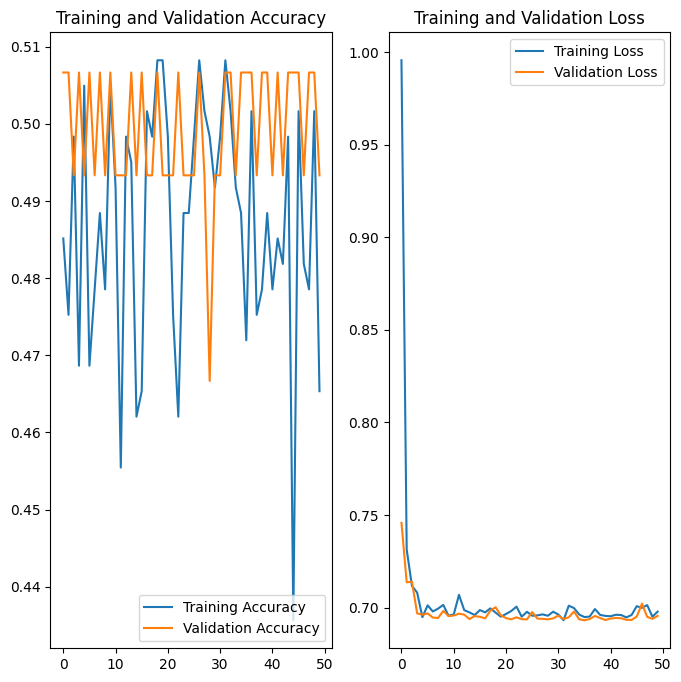

In [208]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
predicted label: sick


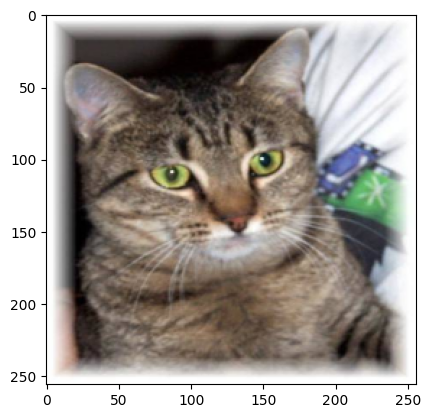

In [209]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [210]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


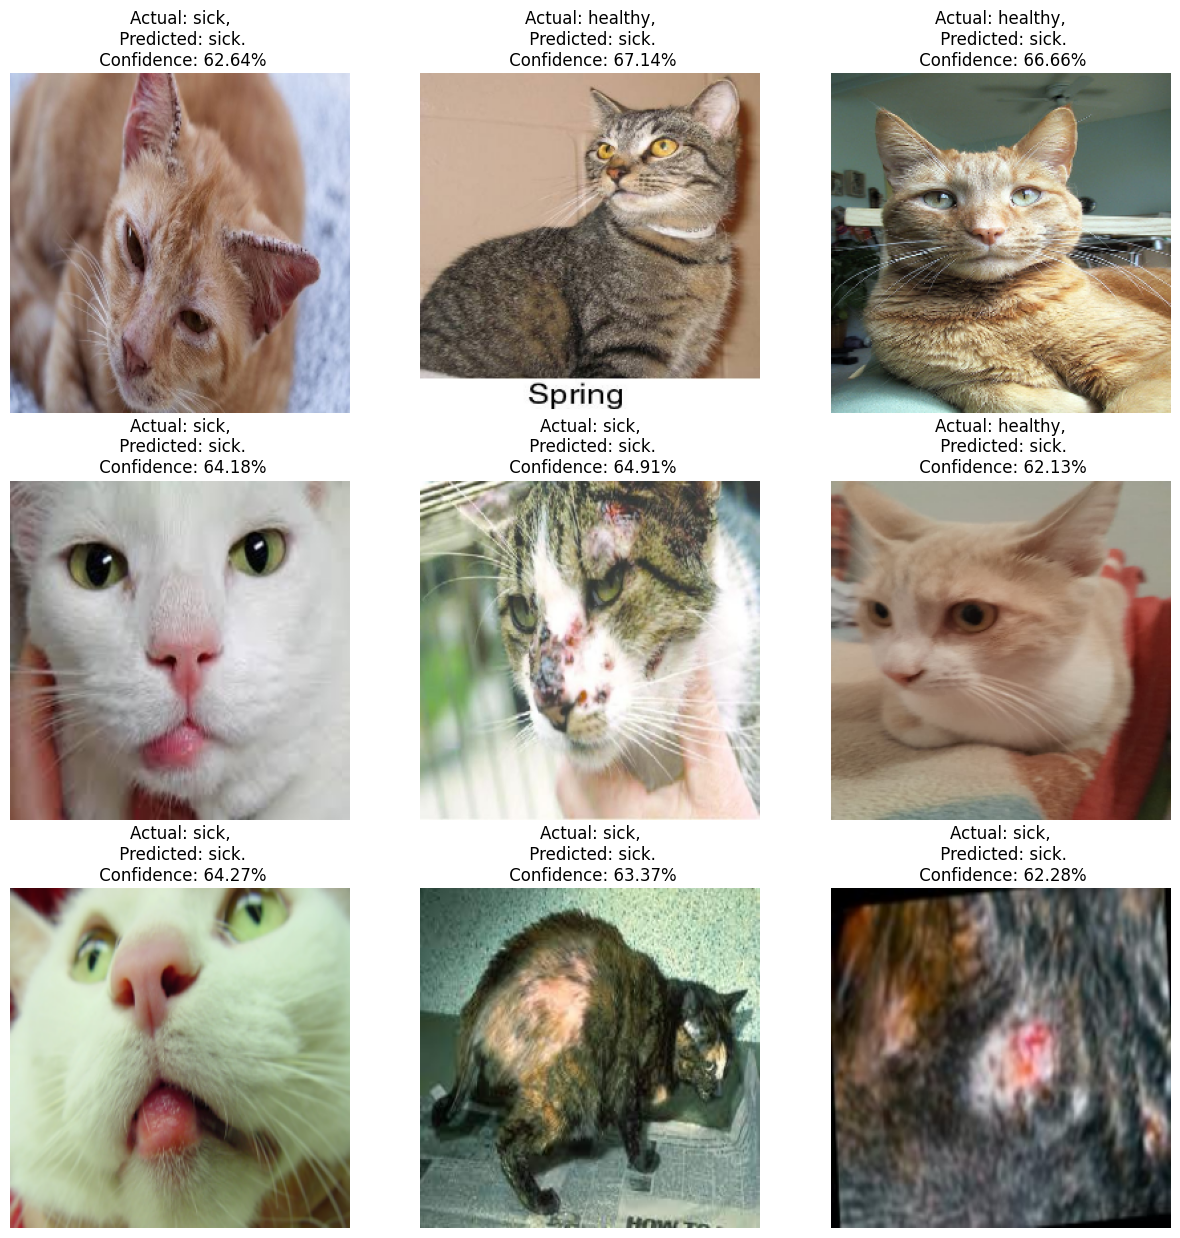

In [214]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [212]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../models'

In [ ]:
model.save("../potatoes.h5")